# Carcass interpolation model

Seismic horizon is a change in rock properties across a boundary between two layers of rock, particularly seismic velocity and density. Such changes are visible in seismic images (even for an untrained eye), and could be automatically detected.

A possible approach to the task of semi-automatic horizon detection is to track reflection by hand on a very sparse grid and use a neural network to interpolate it on the whole seismic (spatial) range. This notebook shows how to do it in details.

* [Dataset](dataset)
* [Model architecture](architecture)
* [Training](training)
* [Validation](validation)
* [Criticism](criticism)
* [Conclusion](conclusion)
* [Suggestions for improvements](suggestions)


In [ ]:
!pip install batchflow
!pip install git+https://github.com/gazprom-neft/seismiqb.git
!pip install einops
!pip install nvidia-ml-py3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gazprom-neft/seismiqb.git to /tmp/pip-req-build-6dw8no23
  Running command git clone --filter=blob:none --quiet https://github.com/gazprom-neft/seismiqb.git /tmp/pip-req-build-6dw8no23
  Resolved https://github.com/gazprom-neft/seismiqb.git to commit 68019916c9b9f6c9a43274272a5076a16343da4f
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nvidia_smi

nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)

In [ ]:
# Necessary imports
import os
import sys; sys.path.insert(0, '/notebooks/akozhevin/_libs/seismiqb/')

from batchflow import Pipeline, Notifier, set_gpus
from batchflow import B, C, M, R, P
from batchflow.models.torch import TorchModel, ResBlock

from seismiqb import SeismicDataset, Horizon, plot
from seismiqb import SeismicSampler, Accumulator3D, RegularGrid

USE_GPU = True

# Set GPU (if needed)
# if USE_GPU: set_gpus(n=1, min_free_memory=0.4);

In [ ]:
# Global parameters
CROP_SHAPE = (1, 128, 128)       # shape of sampled 3D crops
N_ITERS = 350                    # number of train iterations
BATCH_SIZE = 64                  # number of crops inside one batch
MICRO_BATCH = 8
INFERENCE_BATCH_SIZE = 64 * 4

<a id='dataset'></a>
# Dataset

We use only one cube and one horizon at a time. The next cell loads them into one entity `dataset`:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

cube_path = '/content/drive/MyDrive/data/cube.sgy'
horizon_path = '/content/drive/MyDrive/data/carcasses/carcass_of_A' # change the path to extract other horizon

dataset = SeismicDataset({cube_path : horizon_path}, labels_class='horizon')

field = dataset[0]
carcass = field.labels[0]

`field.geometry` can be used to get crops from `.sgy` file in `numpy.ndarray` style. Here indices starts in 0:

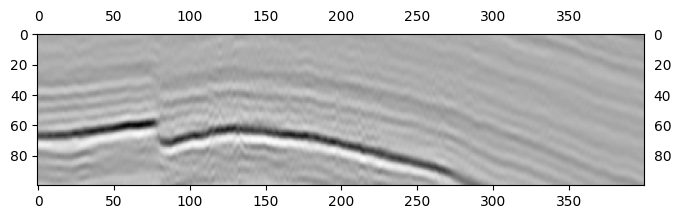

In [ ]:
plot(field.geometry[0, 100:500, 300:400])

`carcass` is an instance of `Horizon` class and has `points` attribute to get carcass positions:

In [ ]:
carcass.points

array([[ 10, 100, 399],
       [ 10, 200, 405],
       [ 10, 300, 408],
       ...,
       [989, 300, 543],
       [989, 400, 576],
       [989, 500, 591]], dtype=int32)

`matrix` attribute stores the same data in 2D array with `-999999` for traces without annotation:

In [ ]:
carcass.matrix[88:93, 88:93]

array([[-999999, -999999,     387, -999999, -999999],
       [-999999, -999999,     387, -999999, -999999],
       [    386,     386,     386,     386,     386],
       [-999999, -999999,     386, -999999, -999999],
       [-999999, -999999,     386, -999999, -999999]], dtype=int32)

It is always nice to look at your data: the next cells show horizon depth map, as well as an example of seismic slice.

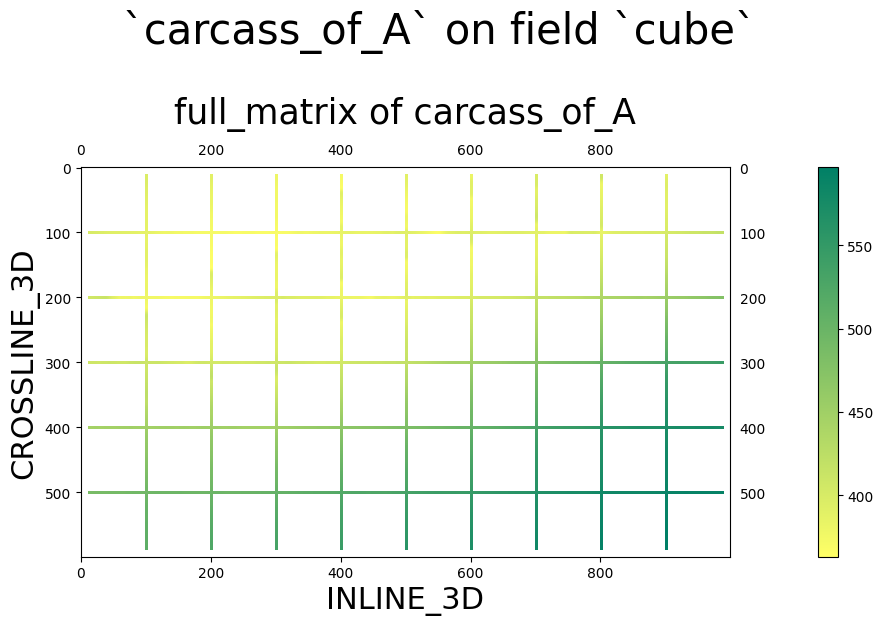

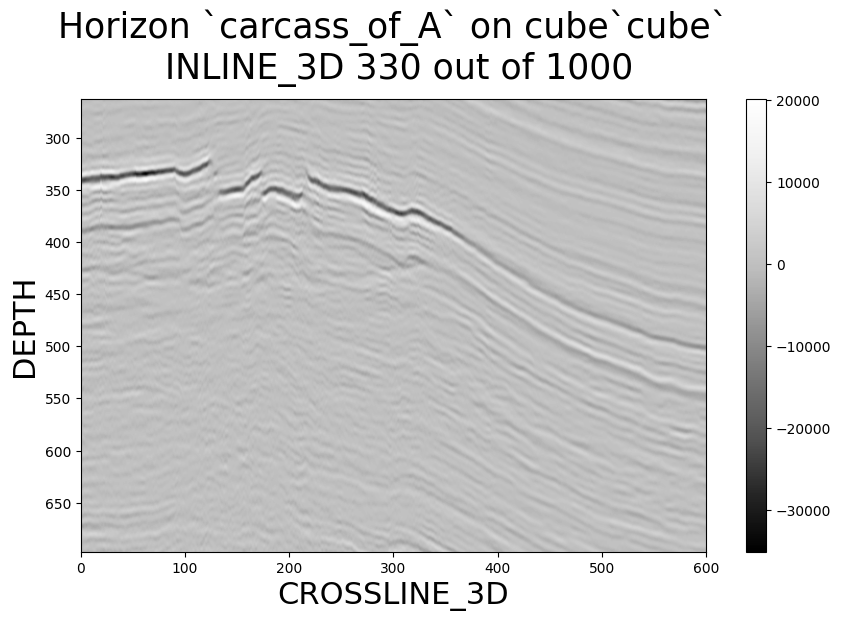

In [ ]:
carcass.show(load_kwargs={'enlarge': True, 'enlarge_width': 3})
carcass.show_slide(330, width=5, zoom='auto')

As we can see, there are very few slices left in the carcass! Note that some of them are `inline`-oriented, some of them are `xline`-oriented: our framework allows to dynamically sample slices in different directions.

As usual, we train the model on 3D crops of data cut from the cube. We need a mechanism of sampling such crops, and that is exactly what `Sampler` is doing. Output of the next cell shows actual sampled slices, that (potentially) can be used at training time. Color corresponds to frequency of the spatial point appearing in the batch.

CPU times: user 2.36 s, sys: 118 ms, total: 2.48 s
Wall time: 3.05 s


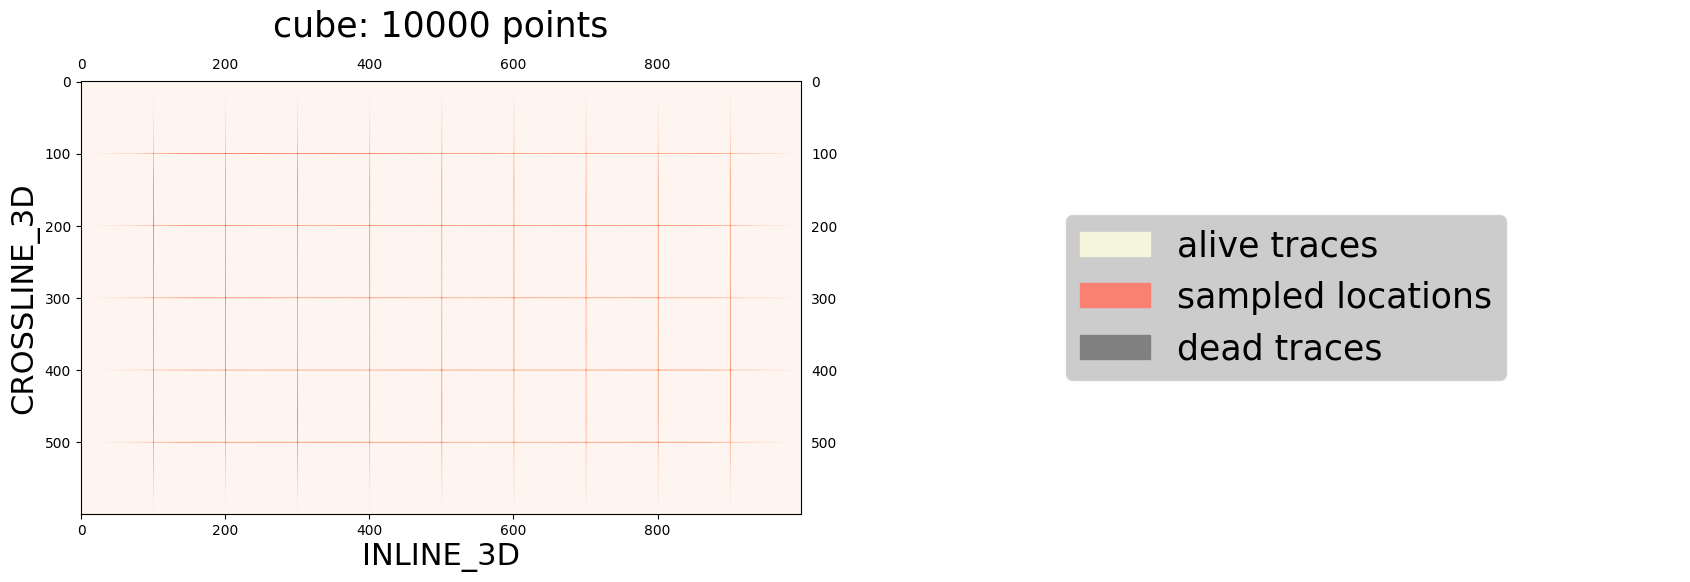

In [ ]:
%%time
train_sampler = SeismicSampler(labels=dataset.labels, crop_shape=CROP_SHAPE,
                               threshold=0.7, randomize_depth=(0.7, 0.3))

# train_sampler.show_locations() # use to show sampled `starting_points`
train_sampler.show_sampled()

<a id='architecture'></a>
# Model architecture

We use convolutional neural network in `hourglass` manner, that consists of following parts:

- Initial processing via [`ResNet`](https://arxiv.org/abs/1512.03385) blocks
- Backbone to encode the image: it is very similar to `ResNet` and downsamples the input by a factor of 16
- Embedding layer
- Decoder, that takes output of the embedding and upsamples it to initial size, using pre-stored skip-connections to include informations from an earlier layers

We optimize Dice-coefficient with `Adam` algorithm. Due to enormous size of crops, we split every batch into pieces (called microbatches), accumulate gradients from each of them and, after the final piece is passed through, update neural network weights. Notably we use `relu6` activation function, as our researches show us that most of the activations are within its range, and all the outliers only hamper the model performance.

In [ ]:
from batchflow.models.torch import UNet

# MODEL_CONFIG = {
#     'encoder': {
#         'type': 'encoder',
#         'num_stages': 2,
#         'order': 'sbd',
#         'downsample': {
#             'layout': 'nc',
#             'channels': '2 * same',
#             'kernel_size': 3,
#             'stride': 2,
#         }
#     },

#     'decoder': {
#         'type': 'decoder',
#         'num_stages': 2,
#         'order': 'ucb',
#         'upsample': {
#             'layout': 'cX',
#             'channels': '2 * same',
#             'kernel_size': 1,
#             'bias': False,
#             'upscale_factor': 2,
#         },
#     },

#     'output': 'sigmoid',
#     # Train configuration
#     'loss': 'bce',
#     'optimizer': 'AdamW',
#     'microbatch': MICRO_BATCH,
#     'amp': USE_GPU,
# }
MODEL_CONFIG = {
    'inputs/targets/classes': 1,
    'head/layout': 'c',
    'head/filters': 1,
    'head/kernel_size': 1,
    'output': 'sigmoid',
    # Train configuration
    'loss': 'bce',
    'optimizer': 'AdamW',
    'microbatch': MICRO_BATCH,
    'amp': USE_GPU,
}

<a id='training'></a>
# Training

Pipeline of training consists of following steps:

- First of all, we create locations of crops to cut (`make_locations` action)
- Then we create masks and load actual seismic data
- As some of the crops are `iline`-oriented, and some of them are `xline`-oriented, we need to force equal shape on all of them. That is what `adaptive_reshape` for!
- We normalize seismic data by standard scaling: this way, most of the data is in $[-3, 3]$ range
- We apply loads of augmentations: after all, our training dataset consists of just a few seismic slices! We are enriching them by using flips, rotations, zoom, elastic transforms.

***Note that we use `transpose` before and after augmentations: turns out, that it is faster to make our crop look like an image and use highly optimized `OpenCV` routines, than to apply transformations along 'unadvantageous' axes.***

In [ ]:
train_template = (
    Pipeline()
    # Initialize model
    .init_model('model', UNet, 'dynamic', config=MODEL_CONFIG)

    # Load data/masks
    .make_locations(generator=train_sampler, batch_size=BATCH_SIZE)
    .create_masks(dst='masks', width=5)
    .load_seismic(dst='images')

    #transforms to images
    # .binarize(src='images')
    .normalize(src='images')
    # .shift_masks(crop=(-1424, -319), scr='masks')

    # Training
    .train_model('model', inputs=B('images'), targets=B('masks'))
)

train_pipeline = train_template << dataset

In [ ]:
%%time
batch = train_pipeline.next_batch()

CPU times: user 951 ms, sys: 36.2 ms, total: 987 ms
Wall time: 1.1 s


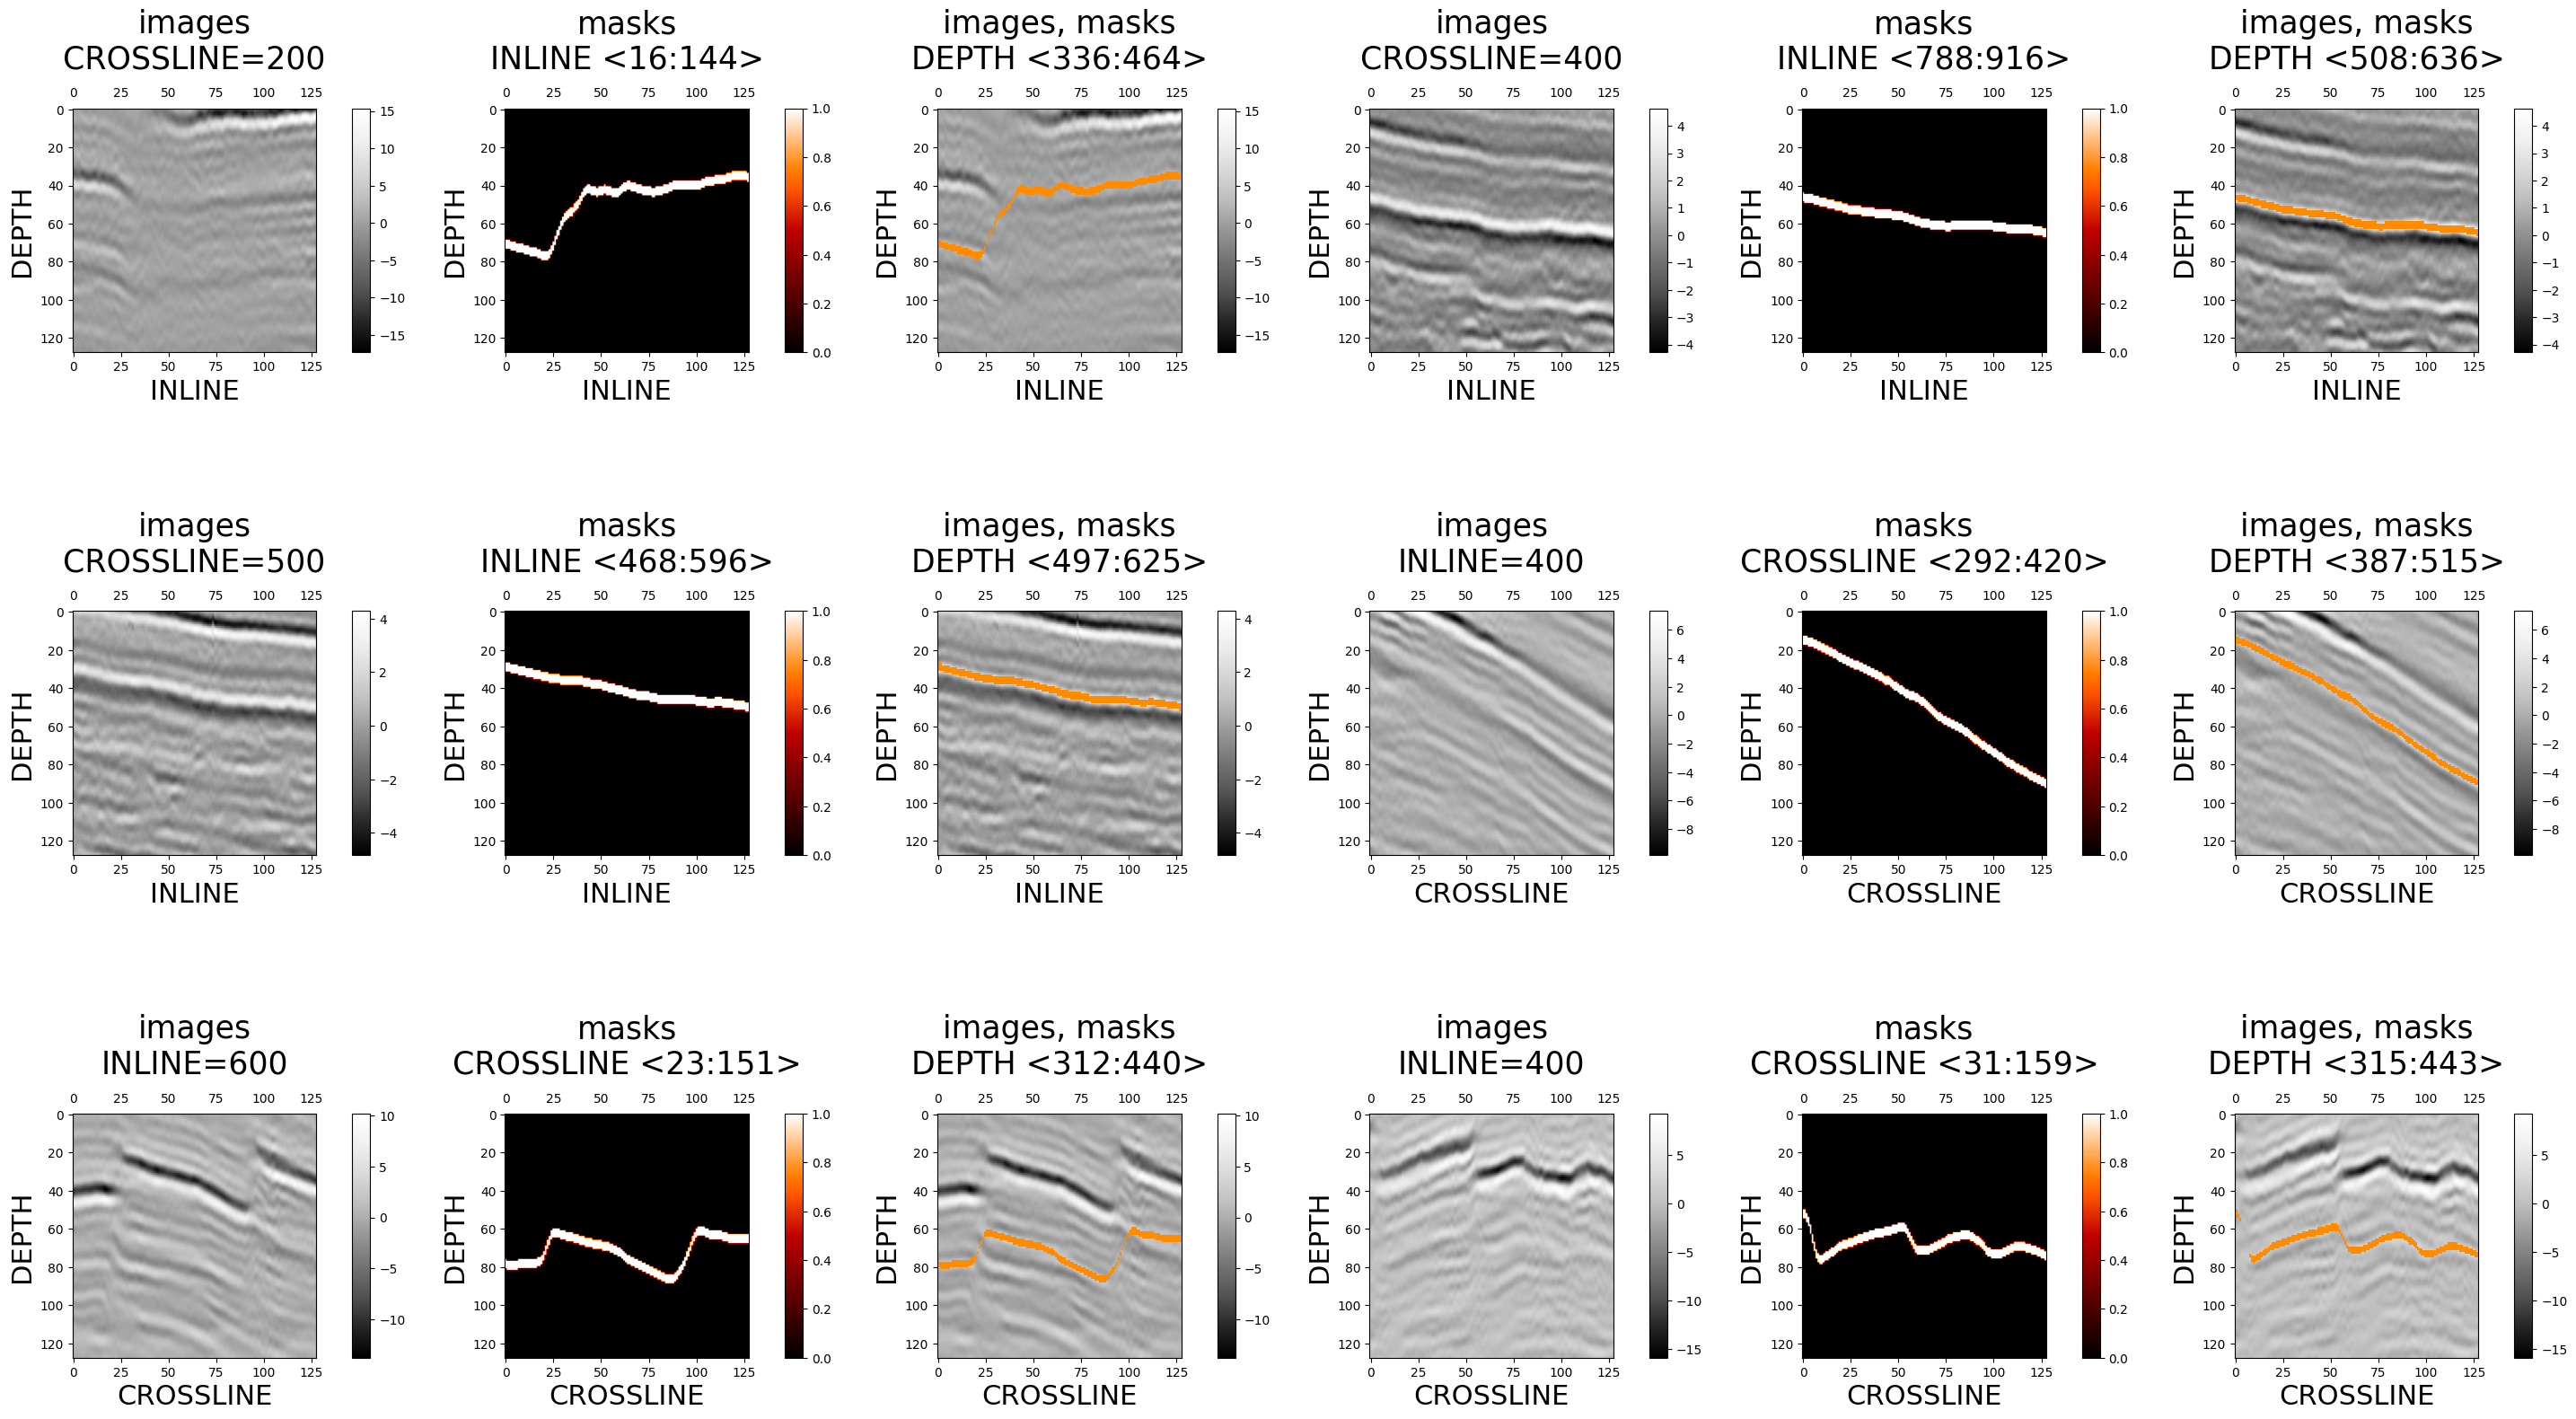

In [ ]:
# Examples of model inputs/targets
batch.plot_roll(n=6, ncols=6, colorbar=True, labelright=False)

In [ ]:
import nvidia_smi

nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)

In [ ]:
%%time
# notifier = Notifier('t', monitors=[M('model').loss_list] + (['gpu', 'gpu_memory'] if USE_GPU else []))
train_pipeline.run(n_iters=N_ITERS) #, notifier=notifier)

# notifier.plot()

In [ ]:
model = train_pipeline.m('model')
model.plot_loss(legend_size=12)

model.information()

We can see that loss platoed rather quickly. High fluctuations suggest that using larger batch size may be of help, as well as the more agressive learning rate scheduler.

# Inference

Now is the perfect time to use our model to reconstruct the whole horizon: we can do so by:
- splitting the cube into chunks that cover the entire seismic range
- for each of them, make a prediction with the model
- aggregate predictions into one giant 3D array
- extract the horizon surface from it

Next cells do exactly that: `make_grid` creates grid of crop-sized chunks, `inference_pipeline` is used to make predictions, and `from_mask` method of `Horizon` allows us to locate the surface inside 3D array.

***Note that `from_mask` is more that capable of detecting and extracting multiple horizons from the volume. In the task of horizon interpolation we expect only one surface, so we take only the biggest of the produced horizons for later evaluation.***

In [ ]:
inference_template = (
    Pipeline()
    # Import model
    .import_model(name='model', source=model)

    # Load data
    .make_locations(generator=C('grid'))
    .load_seismic(dst='images')

    #transforms to images
    # .binarize(src='images')
    .normalize(src='images')


    # Predict with model, then aggregate
    .predict_model('model', inputs=B('images'),
                   outputs='sigmoid', save_to=B('predictions'))
    .update_accumulator(src='predictions', accumulator=C('accumulator'))
)

We use a `RegularGrid` to create define locations of crops that would cover the desired range. `Accumulator3D` is continuously updated with new predictions, allowing us to reduce memory footprint: instead of keeping all of them in memory and aggregating later, we use and discard them right away.

In [ ]:
%%time
ranges = [None, None, [carcass.d_min - 128, carcass.d_max + 128]]

grid = RegularGrid(field=field, orientation=0, ranges=ranges,
                     batch_size=INFERENCE_BATCH_SIZE, crop_shape=CROP_SHAPE)

accumulator_path = 'prediction.hdf5'  # can be `None` if you have enough RAM
accumulator = Accumulator3D.from_grid(grid=grid, fill_value=0.0, path=accumulator_path)

inference_pipeline = inference_template << dataset << {'grid': grid, 'accumulator': accumulator}

In [ ]:
%%time
# notifier = Notifier('t', monitors=['cpu'] + (['gpu', 'gpu_memory'] if USE_GPU else []))
inference_pipeline.run(n_iters=grid.n_iters) #, notifier=notifier)
# notifier.plot()

In [ ]:
%%time
aggregated = accumulator.aggregate()

plot(aggregated[100], title='Prediction from neural network')

horizons = Horizon.from_mask(aggregated[:], field=field, origin=grid.origin, mode='prob')

predicted_horizon = horizons[-1] # the biggest one
predicted_horizon.show()

As we can see, there are some rough patches at the edges, but the overwhelming majority of points is labeled.

Now we apply the same evaluating procedure, as was applied to the target horizon:

In [ ]:
%%time
predicted_horizon.show({'src': 'metrics', 'device': 'cpu', 'supports': 50, 'amortize': False})

As we can see, the quality of tracking is even better, than it was in the original horizon! That is because the model learned on very small amount of slices, where tracked phase was relatively unchanged, and picked the same phase on the rest of the cube points.

Finally, we compare prediction and target horizon head-to-head:

In [ ]:
predicted_horizon.compare(carcass);

In [ ]:
predicted_horizon.dump(f'./{carcass.short_name[-1]}.char')
if accumulator_path:
    os.remove(accumulator_path)

As of now, the model is more than capable of extending a sparse carcass to a whole spatial range of the cube.